<font color='red'> Если нет необходимых библиотек инсталируем их </font>

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import torchvision.datasets
import torchvision.transforms as torch_T
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
import gc
gc.enable()

# Лабораторная №1

In [ ]:
n = 2 # ВАРИАНТ

In [ ]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
X_train = X_train.float().numpy()

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
x = np.array([1, 2])
y = np.array([3, 4])
np.matmul(x, y)

11

# Выбор варианта

Всего 60000 картинок, каждый выбирает картинки из диапазона $[6000(n-1)+1,6000\cdot n]$ где $n$- номер по списку.
Постройте гистограмму для ответов (y_train) и убедитесь, что у вас нет дисбаланса классов. Если есть дисбаланс, устраните его удалением соответствующего класса или удалением картинок. Порог для преобразования в $\{0,1\}$(см. ниже) установите равным:
$$
thr = 0.45 + (n-1)/100
$$

## Преобразуем данные в нули и единицы.

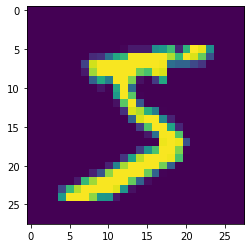

In [ ]:
plt.imshow(X_train[0, :, :])
plt.show()

In [ ]:
# thr = 0.45 # Номер варианта см. список группы
# X_train[X_train>thr] = 1
# X_train[X_train<thr] = 0

## Картинка после преобразования

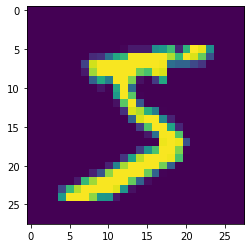

tensor(5)


In [ ]:
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

## Применим EM-алгоритм для смеси распределений Бернулли

Найти выражения для E-шага и M-шага для смеси C штук распределений
Бернулли 
$$
p(X\mid \theta) = \prod_{i=1}^D \sum_{c=1}^C p (x_i|\mu_c)\pi_c, \quad x_i\in \mathbf{R}^N,  \quad \mu\in\mathbf{R}^N
$$
$$
p(z\mid\mu_c) = \prod_{j=1}^N \mu_{cj}^{z_j}(1-\mu_{cj})^{1-z_j}, \quad  z_j\in\{0,1\},
$$

где параметры модели $\theta = \{\mu_{11},\dots,\mu_{1N},\dots,\mu_{C1},\dots,\mu_{CN}, \pi_1,\dots, \pi_C\}$. 

<font color='red'> В отличие от модели на семинаре здесь параметр $\mu$ это вектор размера $N$ !!! </font>

## Задание 1: получить выражения для E-шага


Получить формулы для E-шага. 
$$
q(t_i) = p (t_i\mid x_i,\theta)
$$
$$
\gamma_{i,c} = q(t_i=c) = \dots
$$


<b>Важный трюк 1:</b> при вычислении произведений, можно использовать логарифмирование, при этом, чтобы избежать нулей под логарифмом, можно нули заменять на очень маленькие числа. 

<b>Важный трюк 2:</b> важно избегать числовых ошибок. В какой-то момент вам может понадобиться вычислить формулу следующего вида (если использовать логарифмирование (см. трюк 1)): $\frac{e^{y_i}}{\sum_j e^{y_j}}$, которая называется _softmax_. Когда вы вычисляете показатели степени больших чисел, некоторые числа могут стать бесконечными. Этого можно избежать, разделив числитель и знаменатель на $e^{\max(y)}$: 
$$
\frac{e^{y_i-\max(y)}}{\sum_j e^{y_j - \max(y) )}}.
$$ 
После этого преобразования максимальное значение в знаменателе будет равно единице. Все остальные члены будут вносить меньшие значения. Итак, чтобы вычислить нужную формулу, вы сначала вычитаете максимальное значение из каждой компоненты в векторе $\mathbf{y}$, а затем вычисляете все остальное, как и раньше.


## Задание 2: реализовать E-шаг

In [ ]:


def E_step(X, pi, mu):       
    eps = 1e-6
    def G_c_i(xi, pc, mc):
        return np.matmul(xi, np.log(mc + eps)) + np.matmul((1 - xi), np.log(1 + eps - mc)) + np.log(pc + eps)

    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (D x N), data points
    pi: (C), mixture component weights 
    mu: (C x N), mixture component means
    
    Returns:
    gamma: (C x D), probabilities of clusters for objects
    """
    D = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    N = mu.shape[1] # dimension of each object
    #gamma = np.zeros((C, D)) # distribution q(T)
    log_g = np.zeros((C, D))
    M = np.array([-1e6] * D)

    #print('\tDefine log(g_c_i)')
    #log_g = np.array(list(map(lambda c: np.array(list(map(lambda x: G_c_i(x, pi[c[0]], mu[c[0]]), X))), list(enumerate(log_g)))))
    log_g = np.add((np.matmul(np.log(mu + eps), X.T ) + np.matmul(np.log(1 + eps - mu), (1 - X.T))).T, np.log(pi + eps)).T
    gc.collect()
    # for c in range(C):
    #     M = np.array(list(map(lambda x: x[1] if x[1] >= log_g[c][x[0]] else log_g[c][x[0]], list(enumerate(M))))) 
    M = np.amax(log_g, axis = 0)
    gc.collect()

    

    #print('\tDefine gamma')


    
    # for i in range(D):
    #     gamma[i] = np.exp(log_g.T[i]- M[i])
    #     gamma[i] = gamma[i] / (np.sum(gamma[i]) +  eps)

    gamma = np.exp(log_g.T - M.reshape(D, 1))
    gamma /= (np.sum(gamma, axis = 1) +  eps).reshape(D, 1)

    gc.collect()
    
    #TO DO
    return gamma.T

## Задание 3:  получить выражения для M-шаг


$$
{\cal L}(\theta,q) = \sum_i\sum_c \gamma_{i,c}\left(\sum_{j=1}^N x_{ij}\log(\mu_{cj}) + (1-x_{ij})\log(1-\mu_{cj})+ \log\pi_c\right) \to \max_{\theta}
$$

Составить функцию Лагранжа и получить выражения для $\theta$.

## Задание 4: реализовать M-шаг

In [ ]:
np.array([1]).sum()

1

In [ ]:
def M_step(X, gamma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (D x N), data points
    gamma: (C x D), probabilities of clusters for objects
    Returns:
    pi: (C)
    mu: (C x N)
    """
    D = X.shape[0] # number of objects
    C = gamma.shape[0] # number of clusters
    N = X.shape[1] # dimension of each object
    eps = 1e-24
    #TO DO
    # for c in range(C):
    #     pi[c] = gamma[c].sum() / (gamma.sum() + eps)
    #     for j in range(N):
    #         mu[c][j] = (gamma[c] @  X.T[j]) / (gamma[c].sum() + eps)



    # g_summ = (np.sum(gamma) + eps)
    # for c in range(C):
    #     g_c_summ = np.sum(gamma[c])
    #     pi[c] = g_c_summ / D#g_summ
    #     for j in range(N):
    #         mu[c][j] = (np.matmul(gamma[c],  X.T[j])) / (g_c_summ + eps)

    sum_c = np.sum(gamma, axis = 1)
    pi = sum_c / D
    mu = (gamma @ X) / (sum_c + eps).reshape(C, 1)
    
    gc.collect()
    return pi, mu

## Задание 5: получить функцию потерь

Наконец, нам нужна функция для отслеживания сходимости. Для этой цели мы будем использовать вариационную нижнюю границу $\mathcal{L}$. Мы остановим наши итерации EM, когда $\mathcal{L}$ перестанет сильно изменяться.  Также полезно проверить, что эта функция никогда не уменьшается во время тренировки. Если это так, у вас есть ошибка в вашем коде.

<b>Реализуем функцию, которая будет вычислять $\mathcal{L}$</b> 

$$\mathcal{L}(\theta, q) =\mathbb{E}_{q(T)}\log \frac{p(X,T | \theta)}{q(T|\theta)}  =  \dots$$ 

## Задание 6: реализовать функцию потерь

Не забываем использовать <b>трюк 1</b>.


$$
{\cal L}(\theta,q) = \sum_c\sum_i \gamma_{c,i}\left(\sum_{j=1}^N x_{ij}\log(\mu_{cj}) + (1-x_{ij})\log(1-\mu_{cj})\right)+ \log\pi_c \to \max_{\theta}
$$



In [ ]:
def compute_vlb(X, pi, mu, gamma):
    """
    Each input is numpy array:
    X: (D x N), data points
    gamma: (C x D), distribution q(T)  
    pi: (C)
    mu: (C x N)
    
    Returns value of variational lower bound
    """
    D = X.shape[0] # number of objects
    C = gamma.shape[0] # number of clusters
    N = X.shape[1] # dimension of each object
    eps =1e-24
    #TO DO

    # loss = 0
    # for c in range(C):
    #     for i in range(D):
    #         sum_ = 0
    #         for j in range(N):
    #             sum_ += X[i][j] * np.log(mu[c][j] + eps) + (1 - X[i][j]) * np.log(1 - mu[c][j] + eps)

    #         loss += sum_+ np.log(pi[c] + eps)
    
 
    # for c in range(C):
    #     for i in range(D):
    #         loss += gamma[c][i] * (np.matmul(X_val[i], np.log(mu_val[c] + eps)) + np.matmul((1 - X_val[i]), np.log(1 + eps - mu_val[c]))) + np.log(pi[c] + eps) 
    #     loss -= np.sum(gamma[c] @ np.log(gamma[c] + eps))

    
    loss = np.sum(np.add((gamma * (np.log(mu + eps) @  X.T)).T, np.log(pi + eps)).T + gamma * (np.log(1 + eps - mu) @  (1 - X).T )) - np.sum(gamma * np.log(gamma + eps))
    gc.collect()

    return np.sum(loss)

## Задание 7: внедрение процедуры обучения

Теперь, когда у нас есть шаг E, шаг M и VLB, мы можем реализовать тренировочный цикл. Мы будем инициализировать значения $\pi$, $\mu$ и $\Sigma$ некоторыми случайными числами, обучать до тех пор, пока $\mathcal{L}$ не перестанет меняться, и возвращать полученные точки. Мы также знаем, что алгоритм EM сходится к локальным оптимумам. Чтобы найти лучшие локальные оптимумы, мы перезапустим алгоритм несколько раз с разных (случайных) начальных позиций. Каждое тренировочное испытание должно останавливаться либо при достижении максимального количества итераций, либо когда относительное улучшение становится меньше заданного допуска $$\left|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal {L}_{i-1}}\right| \le \text{rtol}$$.

<b>Начальные данные:</b>
Параметры $\pi_c$ можно задавать одинаковыми, при это не забываем, что сумма равна единице.  Параметры $\mu$ можно моделировать равномерно на отрезке [0.25, 0.75], далее их надо отнормировать.

Также в код можно добавить обработку ситуации, когда целевая функция возвращает nan.

In [ ]:
def rand_pi(C):
    #TO DO
    pic = np.random.uniform(0.25, 0.75, size=(C))
    return pic / pic.sum()


def rand_mu(X, C, N):
    #print('\n', type(X), '\n', type(C), '\n', type(N))
    mu = np.abs(np.random.uniform(0.25, 0.75, size=(C, N)))
    mu /= mu.sum()
    # TO DO
    return mu



def evaluate_EM(X, mu, pi, gamma):
    gamma = E_step(X, pi, mu)
    return compute_vlb(X, pi, mu, gamma)


def train_EM(X, C=10, rtol=1e-3, max_iter=10, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (D, N), data points
    C: int, number of clusters
    '''

    X_train, X_test, _, _ = train_test_split(X, X)

    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    print(N, '\n', d)
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    loss_prev = None
    best_test = None
    losses = {'train':[], 'test':[]}
    
    X = X_train

    for iter_ in range(restarts):
        train_losses = []
        test_losses = []
        print(f'\n\nNew restart {iter_}')
        loss = None
        curr_rel_loss = None
        pi0 = rand_pi(C)
        mu0 = rand_mu(X, C, d) 
        loss = None
        for i in range(max_iter):
            gc.collect()
            pi, mu = pi0, mu0
            #print('\nRun E - step')
            gamma = E_step(X, pi, mu)
            #print('Run M - step')
            pi, mu  = M_step(X, gamma)
            #print('Define Loss')
            loss = compute_vlb(X, pi, mu, gamma)
            if(np.isnan(loss)):
                print('Early stopping')
                break;
            print(f'Step: {i} ', f'Loss {loss:.2f}\n')
            train_losses.append(loss)
            test_losses.append(evaluate_EM(X_test, mu, pi, gamma))
            pi0 = pi
            mu0 = mu
            if loss_prev != None:
                curr_rel_loss = np.abs(loss_prev - loss)/np.abs(loss_prev)
                loss_prev = loss
            else:
                loss_prev = loss
            if curr_rel_loss!=None and curr_rel_loss < rtol:
                break

        if best_loss!=None:

            if (loss_prev>best_loss):
                best_loss = loss
                best_test = evaluate_EM(X_test, mu, pi, gamma)
                best_mu = mu
                best_pi = pi
                losses['train'] = train_losses
                losses['test'] = test_losses
        else:
            best_loss = loss
            best_test = evaluate_EM(X_test, mu, pi, gamma)
            best_mu = mu
            best_pi = pi
            losses['train'] = train_losses
            losses['test'] = test_losses
    return  losses, best_pi, best_mu, best_test, best_loss



    


In [ ]:
%%time
#losses, pi, mu = train_EM(X_train_var.reshape(-1, 28*28), restarts= 1, max_iter=10)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


In [ ]:
#plt.imshow(mu[0].reshape(28,28))

## Задание 8

Обучить модель и ответить на следующие вопросы.

1. Построить графики для всех математических ожиданий в виде цифр (т.е. преобразовать вектора в матрицы) Похожи ли получившиеся средние на цифры? (С=10)
2. Построить несколько картинок для цифр из обучающей выборки и соответствующих математических ожиданий на одном графике для одного класса. Проделать это для нескольких классов. Как можно интерпретировать результат?
3. Разбить на обучающую и тестовую выборки, и определить оптимальное кол-во кластеров с помощью графиков правдоподобия для обучения и теста. 
4. Попробовать улучшить результат (варьировать различные параметры), подумать как оценивать качество.
5. Написать вывод.


In [ ]:

X_train_var = X_train[6000*(n-1): 6000*n]
Y_train_var = y_train[6000*(n-1): 6000*n]
X_train_var.shape

(6000, 28, 28)

In [ ]:
thr = 0.45 + (n - 1) / 100 # Номер варианта см. список группы
X_train_var[X_train_var > thr] = 1
X_train_var[X_train_var < thr] = 0
np.random.shuffle(X_train_var)

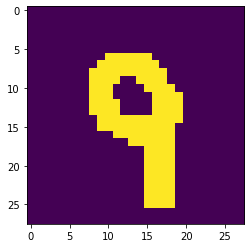

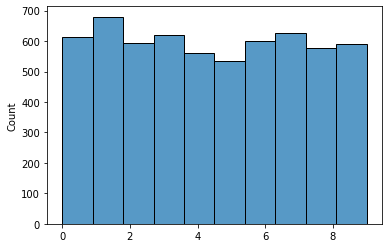

In [ ]:
plt.imshow(X_train_var[0])
plt.show()
sns.histplot(Y_train_var, bins = 10)

In [ ]:
X_train_var.reshape(-1, 28*28).shape

(6000, 784)

In [ ]:
%%time
losses, pi, mu, _, _ = train_EM(X_train_var.reshape(-1, 28*28))#, restarts = 10, max_iter= 10, C = 10, rtol = 1e-6)#, restarts= 100, max_iter = 100, rtol = 1e-6)

6000 
 784


New restart 0
Step: 0  Loss -1120564.20

Step: 1  Loss -978596.77

Step: 2  Loss -935867.65

Step: 3  Loss -918384.61

Step: 4  Loss -910793.22

Step: 5  Loss -905883.87

Step: 6  Loss -902656.10

Step: 7  Loss -901266.42

Step: 8  Loss -900494.85



New restart 1
Step: 0  Loss -1119392.57

Step: 1  Loss -974523.52

Step: 2  Loss -943682.90

Step: 3  Loss -931373.85

Step: 4  Loss -924632.89

Step: 5  Loss -919434.53

Step: 6  Loss -914286.32

Step: 7  Loss -910562.45

Step: 8  Loss -908360.64

Step: 9  Loss -906141.03



New restart 2
Step: 0  Loss -1132777.63

Step: 1  Loss -964957.43

Step: 2  Loss -928369.88

Step: 3  Loss -916949.21

Step: 4  Loss -911723.46

Step: 5  Loss -907836.23

Step: 6  Loss -904176.62

Step: 7  Loss -900777.59

Step: 8  Loss -898113.13

Step: 9  Loss -896316.91



New restart 3
Step: 0  Loss -1146080.56

Step: 1  Loss -965456.06

Step: 2  Loss -932945.88

Step: 3  Loss -921055.55

Step: 4  Loss -914317.76

Step: 5  Loss -911133.58

Step: 6  Lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


Early stopping


New restart 7
Step: 0  Loss -1167892.72

Step: 1  Loss -999151.60

Step: 2  Loss -951310.02

Step: 3  Loss -928312.02

Step: 4  Loss -917811.79

Step: 5  Loss -911428.94

Step: 6  Loss -907300.17

Step: 7  Loss -904042.85

Step: 8  Loss -901641.00

Step: 9  Loss -899875.95



New restart 8
Step: 0  Loss -1162483.12

Step: 1  Loss -977293.32

Step: 2  Loss -933008.58

Step: 3  Loss -920015.66

Step: 4  Loss -914126.80

Step: 5  Loss -910353.52

Step: 6  Loss -907639.39

Step: 7  Loss -905633.81

Step: 8  Loss -903961.98

Step: 9  Loss -902490.26



New restart 9
Step: 0  Loss -1145095.90

Step: 1  Loss -972840.91

Step: 2  Loss -938152.01

Step: 3  Loss -922786.29

Step: 4  Loss -913373.63

Step: 5  Loss -906559.26

Step: 6  Loss -902271.84

Step: 7  Loss -899121.31

Step: 8  Loss -897288.27

Step: 9  Loss -896545.14

CPU times: user 1min 48s, sys: 47.6 s, total: 2min 36s
Wall time: 1min 42s


Построим получивщиеся средние значения

[0.14523552 0.14024188 0.11419309 0.0974065  0.07518014 0.06303019
 0.06145971 0.1153584  0.10261001 0.08528357]


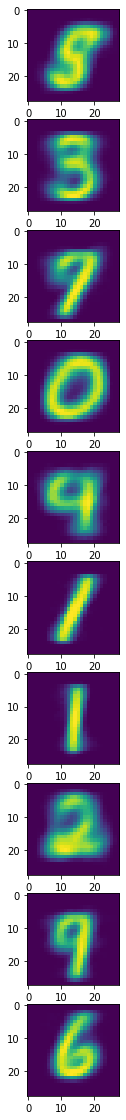

In [ ]:
# mu[mu > thr] = 1
# mu[mu < thr] = 0
print(pi)
fig, ax = plt.subplots(len(mu), 1, figsize = (len(mu) * 20, 20))
for i, v in enumerate(mu):
    ax[i].imshow(v.reshape(28, 28))

Большинство средних значений отчетливо похожи на цифры

In [ ]:
def predict_cluster(X, pi, mu):
    gamma = E_step(X.reshape(-1, 28*28), pi, mu)
    new_pi, new_mu = M_step(X.reshape(-1, 28*28), gamma)
    return mu[np.argmax(new_pi)].reshape(28, 28)



Построим средние для нескольких изображений в каждом кластере

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


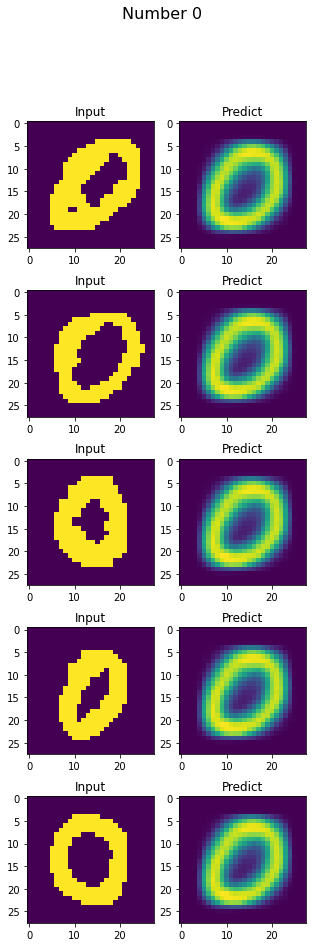

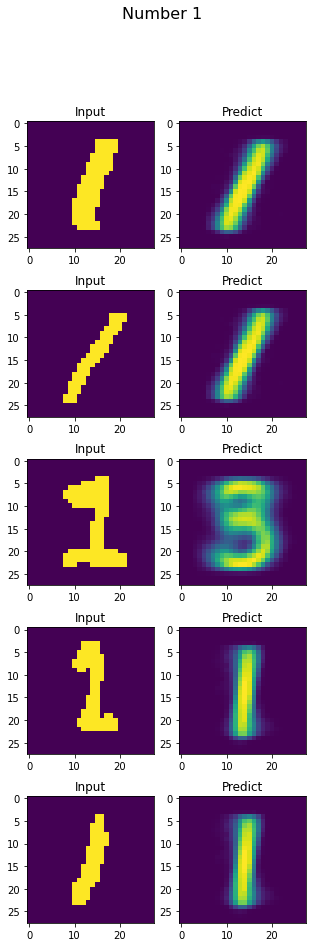

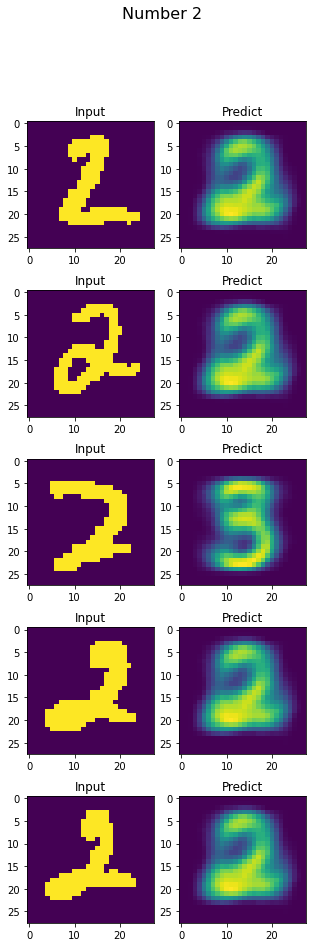

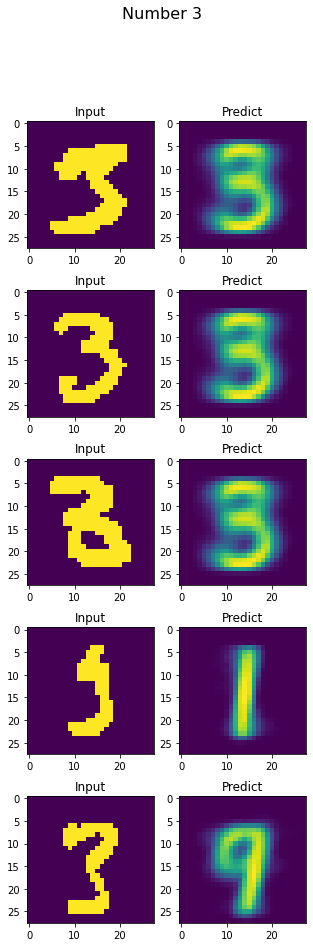

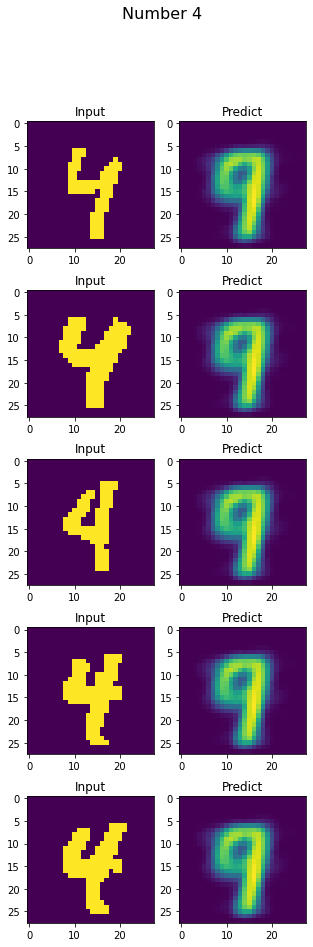

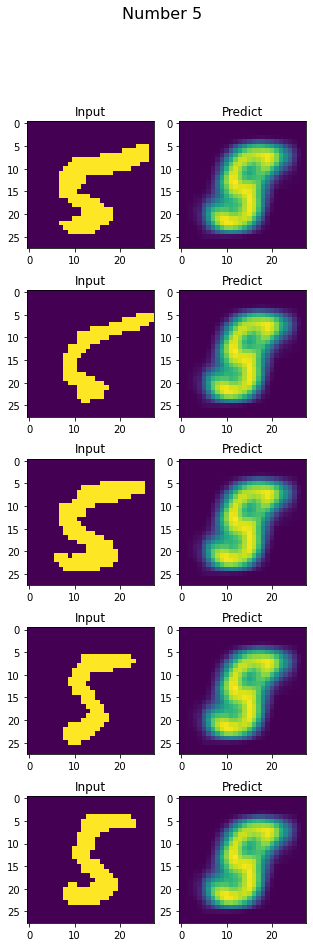

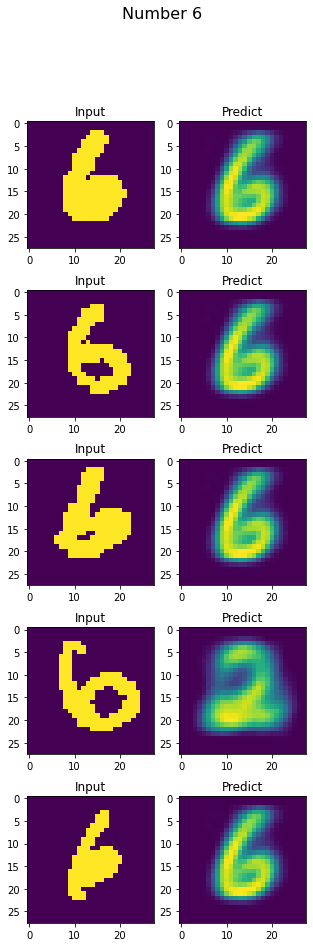

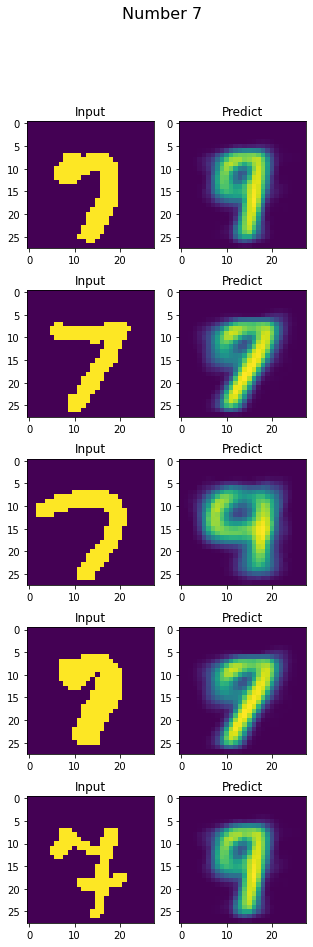

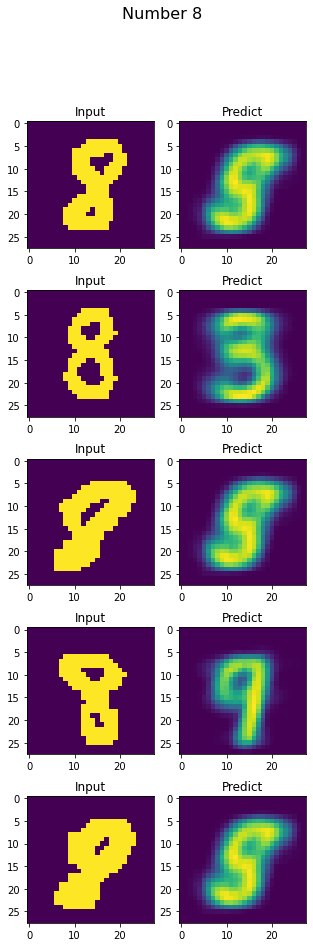

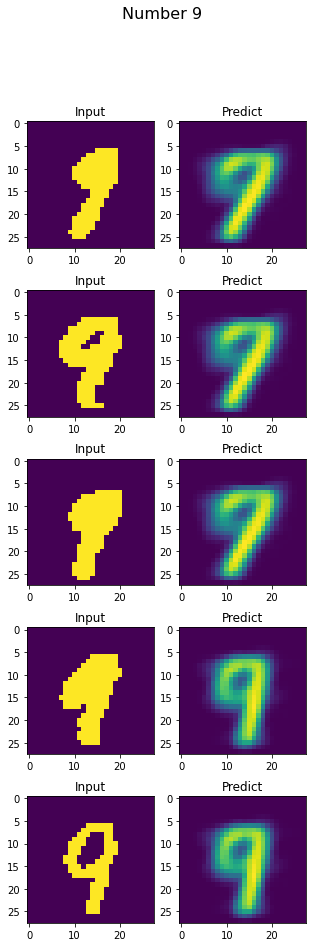

In [ ]:
%matplotlib inline
n_ = 5
X_ = X_train[6000*(n_-1): 6000*n_]
Y_ = y_train[6000*(n_-1): 6000*n_]


X_[X_ > thr] = 1
X_[X_ < thr] = 0

XY = np.array(list(zip(X_, Y_)))
labels = set(Y_.tolist())

for l in labels:
    X_ = XY[XY.T[1] == l].T[0][:5]
    fig, ax = plt.subplots(len(X_), 2, figsize = (5, 3 * len(X_)))
    fig.suptitle(f'Number {l}', fontsize=16)
    for i, x in enumerate(X_):
        pred = predict_cluster(np.array([x.reshape(28*28)]), pi, mu)
        ax[i][0].imshow(x)
        ax[i][1].imshow(pred)
        ax[i][0].set_title('Input')
        ax[i][1].set_title('Predict')
    plt.show()

        


In [ ]:
# fig, ax = plt.subplots(len(losses['train']), 1, figsize = (10,15  * len(losses['train'])))
# for i, line in enumerate(losses['train']):
#     #if(i == 8):
        
#         ax[i].plot(np.arange(0, len(line)), line, label = 'Train Loss')
#         ax[i].plot(np.arange(0, len(line)), losses['test'][i], label = 'Test Loss')
#         ax[i].legend(loc = 2)

Определим оптимальное количество кластеров с помощью разбиения на обучающую выборку и тестовую 

In [ ]:
def rand_pi(C):
    #TO DO
    pic = np.random.uniform(0.25, 0.75, size=(C))
    return pic / pic.sum()


def rand_mu(X, C, N):
    #print('\n', type(X), '\n', type(C), '\n', type(N))
    mu = np.abs(np.random.uniform(0.25, 0.75, size=(C, N)))
    mu /= mu.sum()
    # TO DO
    return mu



def evaluate_EM(X, mu, pi, gamma):
    gamma = E_step(X, pi, mu)
    return compute_vlb(X, pi, mu, gamma)


def train_EM(X, C=10, rtol=1e-3, max_iter=10, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (D, N), data points
    C: int, number of clusters
    '''

    X_train, X_test, _, _ = train_test_split(X, X)

    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    #print(N, '\n', d)
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    loss_prev = None
    best_test = None
    losses = {'train':[], 'test':[]}
    
    X = X_train

    for iter_ in range(restarts):
        train_losses = []
        test_losses = []
        #print(f'\n\nNew restart {iter_}')
        loss = None
        curr_rel_loss = None
        pi0 = rand_pi(C)
        mu0 = rand_mu(X, C, d) 
        loss = None
        for i in range(max_iter):
            gc.collect()
            pi, mu = pi0, mu0
            #print('\nRun E - step')
            gamma = E_step(X, pi, mu)
            #print('Run M - step')
            pi, mu  = M_step(X, gamma)
            #print('Define Loss')
            loss = compute_vlb(X, pi, mu, gamma)
            if(np.isnan(loss)):
                #print('Early stopping')
                break;
            #print(f'Step: {i} ', f'Loss {loss:.2f}\n')
            train_losses.append(loss)
            test_losses.append(evaluate_EM(X_test, mu, pi, gamma))
            pi0 = pi
            mu0 = mu
            if loss_prev != None:
                curr_rel_loss = np.abs(loss_prev - loss)/np.abs(loss_prev)
                loss_prev = loss
            else:
                loss_prev = loss
            if curr_rel_loss!=None and curr_rel_loss < rtol:
                break

        if best_loss!=None:

            if (loss_prev>best_loss):
                best_loss = loss
                best_test = evaluate_EM(X_test, mu, pi, gamma)
                best_mu = mu
                best_pi = pi
        else:
            best_loss = loss
            best_test = evaluate_EM(X_test, mu, pi, gamma)
            best_mu = mu
            best_pi = pi
        losses['train'] = np.concatenate([losses['train'], train_losses])
        losses['test'] = np.concatenate([losses['test'], test_losses])
    return  losses, best_pi, best_mu, best_test, best_loss



    


In [ ]:
def Get_Test_Train_Loss_EM(C):
    np.random.seed(42)
    losses, _, _, _, _ = train_EM(X_train_var.reshape(-1, 28*28), C = C,  max_iter = 50, restarts= 10, rtol= 1e-6)
    return np.amax(np.array(losses['test']).reshape(-1)), np.amax(np.array(losses['train']).reshape(-1))

In [ ]:
!pip install swifter
import swifter
import itertools
import pandas as pd

In [ ]:
%%time
C = np.arange(5, 20, 1)
df = pd.DataFrame({'C':C})
test_losses = []
train_losses = []
df['Losses'] = df.swifter.apply(lambda x: Get_Test_Train_Loss_EM(x[0]), axis = 1)


Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: Runti

CPU times: user 5min 8s, sys: 1min 54s, total: 7min 3s
Wall time: 57min 9s


In [ ]:
test_losses = df['Losses'].apply(lambda x: x[0])
train_losses = df['Losses'].apply(lambda x: x[1])
test_losses

0    -306811.368412
1    -302384.554220
2    -301435.327244
3    -300590.347984
4    -302068.732752
5    -304056.871680
6    -306508.130228
7    -308541.183507
8    -312052.252876
9    -315243.928549
10   -319377.918065
11   -323028.506030
12   -329535.471327
13   -331003.975890
14   -340574.433013
Name: Losses, dtype: float64

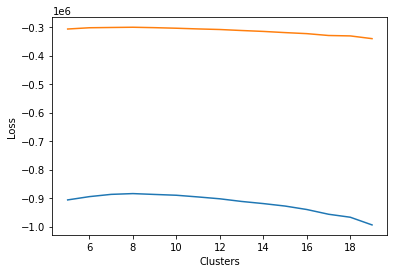

In [ ]:
%matplotlib inline
plt.plot(C, train_losses, label = 'Train losses')
plt.plot(C, test_losses, label = 'Test losses')
plt.xlabel('Clusters')
plt.xlim
plt.ylabel('Loss')
plt.show()

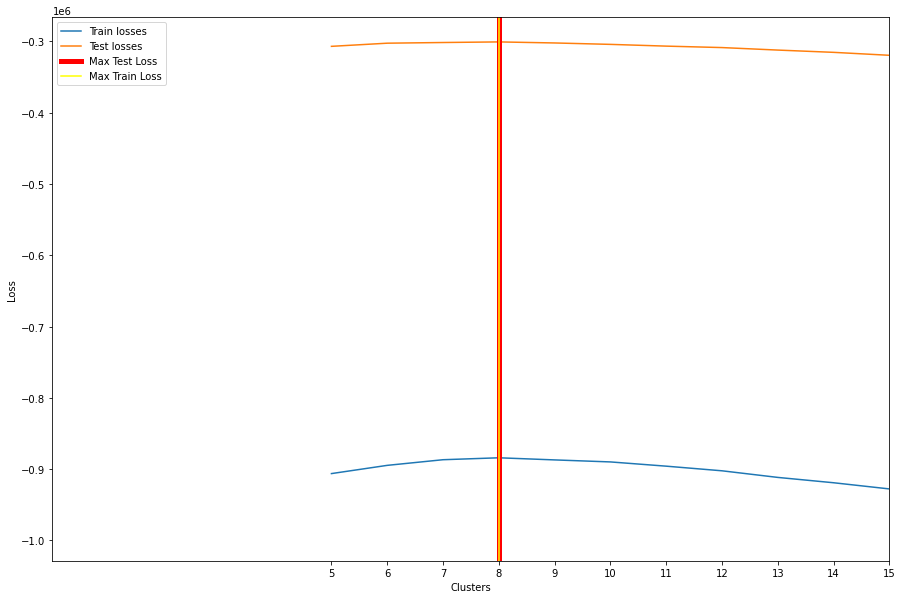

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(C, train_losses, label = 'Train losses')
plt.plot(C, test_losses, label = 'Test losses')
plt.xlabel('Clusters')
plt.xticks(C)
plt.xlim(0, 15)
plt.ylabel('Loss')
plt.axvline(C[np.argmax(test_losses)], color = 'r', label = 'Max Test Loss', linewidth = 5)
plt.axvline(C[np.argmax(train_losses)], color = 'yellow', label = 'Max Train Loss')
plt.legend()
plt.show()

Функция ошибки для обучающей и тестовой выборки имеет схожую вогнутую форму с максимумом при 8-ми кластерах.
Однако данный выввод является не физичным и скорее подводит к мысли, что нужно как-то усовершенствовать функционал качества. 

# Варьирование параметров.

Варьируя количество итераций и порог затухания, постараемся улучшить модель.

За функционал качества возьмем так же ошибку на тестовой выборке.

In [ ]:
def rand_pi(C):
    #TO DO
    pic = np.random.uniform(0.25, 0.75, size=(C))
    return pic / pic.sum()


def rand_mu(X, C, N):
    #print('\n', type(X), '\n', type(C), '\n', type(N))
    mu = np.abs(np.random.uniform(0.25, 0.75, size=(C, N)))
    mu /= mu.sum()
    # TO DO
    return mu



def evaluate_EM(X, mu, pi, gamma):
    gamma = E_step(X, pi, mu)
    return compute_vlb(X, pi, mu, gamma)


def train_EM(X, C=10, rtol=1e-3, max_iter=10, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (D, N), data points
    C: int, number of clusters
    '''

    X_train, X_test, _, _ = train_test_split(X, X)

    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    #print(N, '\n', d)
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    loss_prev = None
    best_test = None
    losses = {'train':[], 'test':[]}
    
    X = X_train

    for iter_ in range(restarts):
        train_losses = []
        test_losses = []
        #print(f'\n\nNew restart {iter_}')
        loss = None
        curr_rel_loss = None
        pi0 = rand_pi(C)
        mu0 = rand_mu(X, C, d) 
        loss = None
        for i in range(max_iter):
            gc.collect()
            pi, mu = pi0, mu0
            #print('\nRun E - step')
            gamma = E_step(X, pi, mu)
            #print('Run M - step')
            pi, mu  = M_step(X, gamma)
            #print('Define Loss')
            loss = compute_vlb(X, pi, mu, gamma)
            if(np.isnan(loss)):
                #print('Early stopping')
                break;
            #print(f'Step: {i} ', f'Loss {loss:.2f}\n')
            train_losses.append(loss)
            test_losses.append(evaluate_EM(X_test, mu, pi, gamma))
            pi0 = pi
            mu0 = mu
            if loss_prev != None:
                curr_rel_loss = np.abs(loss_prev - loss)/np.abs(loss_prev)
                loss_prev = loss
            else:
                loss_prev = loss
            if curr_rel_loss!=None and curr_rel_loss < rtol:
                break

        if best_loss!=None:

            if (loss_prev>best_loss):
                best_loss = loss
                best_test = evaluate_EM(X_test, mu, pi, gamma)
                best_mu = mu
                best_pi = pi
        else:
            best_loss = loss
            best_test = evaluate_EM(X_test, mu, pi, gamma)
            best_mu = mu
            best_pi = pi
        losses['train'] = np.concatenate([losses['train'], train_losses])
        losses['test'] = np.concatenate([losses['test'], test_losses])
    return  losses, best_pi, best_mu, best_test, best_loss



    


In [ ]:
def Get_Test_Loss_EM(iters = 10, rt = 1e-3, C = 10):
    np.random.seed(42)
    losses, _, _, _, _ = train_EM(X_train_var.reshape(-1, 28*28),  max_iter = iters, rtol= rt, C = C)
    return np.amax(np.array(losses['test']).reshape(-1))

In [ ]:
!pip install swifter
import swifter
import itertools
import pandas as pd

In [ ]:
parameters = {'max_iter':[10, 25, 50]
              , 'rtol':[1e-3, 1e-6, 1e-12, 1e-24]
              , 'C':[8, 10, 15, 20]}
df = pd.DataFrame({'C':[], 'max_iter':[], 'rtol':[]})
for i in itertools.product(parameters['C'], parameters['max_iter'], parameters['rtol']):
           print(list(i))
           df.loc[df.shape[0]] = i

[8, 10, 0.001]
[8, 10, 1e-06]
[8, 10, 1e-12]
[8, 10, 1e-24]
[8, 25, 0.001]
[8, 25, 1e-06]
[8, 25, 1e-12]
[8, 25, 1e-24]
[8, 50, 0.001]
[8, 50, 1e-06]
[8, 50, 1e-12]
[8, 50, 1e-24]
[10, 10, 0.001]
[10, 10, 1e-06]
[10, 10, 1e-12]
[10, 10, 1e-24]
[10, 25, 0.001]
[10, 25, 1e-06]
[10, 25, 1e-12]
[10, 25, 1e-24]
[10, 50, 0.001]
[10, 50, 1e-06]
[10, 50, 1e-12]
[10, 50, 1e-24]
[15, 10, 0.001]
[15, 10, 1e-06]
[15, 10, 1e-12]
[15, 10, 1e-24]
[15, 25, 0.001]
[15, 25, 1e-06]
[15, 25, 1e-12]
[15, 25, 1e-24]
[15, 50, 0.001]
[15, 50, 1e-06]
[15, 50, 1e-12]
[15, 50, 1e-24]
[20, 10, 0.001]
[20, 10, 1e-06]
[20, 10, 1e-12]
[20, 10, 1e-24]
[20, 25, 0.001]
[20, 25, 1e-06]
[20, 25, 1e-12]
[20, 25, 1e-24]
[20, 50, 0.001]
[20, 50, 1e-06]
[20, 50, 1e-12]
[20, 50, 1e-24]


In [ ]:
%%time
df['loss'] = df.swifter.apply(lambda x: Get_Test_Loss_EM(iters = int(x[1]), rt = x[2], C = int(x[0])), axis = 1)
df = df.sort_values('loss', ascending = False)
df.head()

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: Runti

CPU times: user 18min 33s, sys: 7min 18s, total: 25min 52s
Wall time: 2h 1min 7s


In [ ]:
df = df.sort_values('loss', ascending = False)
df.head()

,C,max_iter,rtol,loss
10,8.0,50.0,1.000000e-12,-300590.347984
11,8.0,50.0,1.000000e-24,-300590.347984
9,8.0,50.0,1.000000e-06,-300590.347984
5,8.0,25.0,1.000000e-06,-300715.458376
7,8.0,25.0,1.000000e-24,-300715.458376


In [ ]:
display(df)

,C,max_iter,rtol,loss
10,8.0,50.0,1.000000e-12,-300590.347984
11,8.0,50.0,1.000000e-24,-300590.347984
9,8.0,50.0,1.000000e-06,-300590.347984
5,8.0,25.0,1.000000e-06,-300715.458376
7,8.0,25.0,1.000000e-24,-300715.458376
6,8.0,25.0,1.000000e-12,-300715.458376
4,8.0,25.0,1.000000e-03,-301109.372027
8,8.0,50.0,1.000000e-03,-301109.372027
1,8.0,10.0,1.000000e-06,-302726.346561
0,8.0,10.0,1.000000e-03,-302726.346561


Как можно судить по таблице, наилучшие результаты достигаются при 50-ти итерациях вне зависимости от порога затухания и снова при 8-ми кластерах.



# Вывод

Метод кластеризации рукописных цифр с помощью EM алгоритма, изученный в данной работе, действительно позволяет достаточно хорошо классифицировать рукописные цифры, хоть и с погрешностями.

К сожалению, модель плохо борится с зашумлением изображенний.

Возможно, так как поставлена задача обработки изображений, для функционала качества стоит использовать метрики, используемые в сегментациях изображения, такие как: коэффициент Серенса - Дайса (DICE coefficient) - мера подобия двух множеств, пересечение объединения (IoU - Intersection-Over-Union или  Jaccard Index)

Для данного варианта задачи, 8 кластеров является наиболее оптималным количеством, если опираться на функцию потерь тестовой выборки.

Так же, с помощью варьирования параметров был получен наилучший результат функции максимального правдоподобия на тестовой выборке при 8-ми классах, 50-ти итерациях алгоритма и порогом затухания в 1e-6.